# Fire Prediction - Sentinel Hub API Integration

This notebook demonstrates how to extract metadata from Sentinel-2 XML files and integrate with the Sentinel Hub API for fire prediction analysis.

## Objectives:
- Extract essential metadata from XML files (coordinates, dates, tile info)
- Transform coordinates from UTM to WGS84
- Create Sentinel Hub API requests for pre/post fire imagery
- Prepare data for fire damage analysis

## Requirements:
- Valid Sentinel Hub credentials (CLIENT_ID and CLIENT_SECRET) in `.env` file
- XML metadata files from Sentinel-2 imagery
- Python libraries: sentinelhub, pyproj, shapely

## Usage:
1. Run all cells in sequence
2. Check the summary section for pipeline status
3. Use the created API requests to download satellite data

In [4]:
# Sentinel Hub API Testing for Fire Prediction
# Metadata extraction from XML files and Sentinel Hub API integration

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import xml.etree.ElementTree as ET
import pickle
import glob
from pathlib import Path
from typing import Dict, List, Tuple, Optional
import datetime as dt

# Data handling and visualization
import matplotlib.pyplot as plt
import numpy as np

# Geospatial libraries
import pyproj
from shapely.geometry import box
from shapely.ops import transform

# Sentinel Hub API
from sentinelhub import CRS, BBox, DataCollection, MimeType, SentinelHubRequest, SHConfig, generate_evalscript
from sentinelhub.api.catalog import get_available_timestamps

# Cloud detection (optional)
from s2cloudless import S2PixelCloudDetector

# Load environment variables
from dotenv import load_dotenv
load_dotenv()

print(" All libraries imported successfully!")

 All libraries imported successfully!


In [5]:
# Configuration Setup for Sentinel Hub API

# Load credentials from environment variables
CLIENT_ID = os.getenv('CLIENT_ID', None)
CLIENT_SECRET = os.getenv('CLIENT_SECRET', None)

# Initialize Sentinel Hub configuration
config = SHConfig()

# Set credentials if available
if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET
    print("Sentinel Hub credentials configured successfully!")
    print(f"Client ID: {CLIENT_ID[:8]}...")
else:
    print("   Sentinel Hub credentials not found in environment variables")
    print("   Set CLIENT_ID and CLIENT_SECRET in your .env file to use the API")
    print("   You can still use the metadata extraction functionality")

print("\nConfiguration ready!")

Sentinel Hub credentials configured successfully!
Client ID: 26aa2248...

Configuration ready!


# 1. Metadata Extraction Classes

This section contains the core classes for extracting metadata from Sentinel-2 XML files and integrating with the Sentinel Hub API.

##  Features:
- **MetadataExtractor**: Extracts essential data from XML metadata files
- **SentinelHubDataExtractor**: Creates API requests from extracted metadata
- **Coordinate transformation**: UTM to WGS84 conversion
- **Fire analysis support**: Pre/post fire data extraction

In [6]:
class MetadataExtractor:
    """
    A robust class to extract essential metadata from Sentinel-2 XML files
    for use with Sentinel Hub API
    """
    
    def __init__(self, xml_folder_path: str):
        """
        Initialize the MetadataExtractor
        
        Args:
            xml_folder_path (str): Path to the folder containing XML files
        """
        self.xml_folder_path = Path(xml_folder_path)
        self.metadata_cache = {}
    

    def extract_geospatial_metadata(country_id, pkl_path, when='pre', resolution=10):
        """
        Extract geospatial metadata from XML and save to pickle file.
        
        Params:
            - country_id (str): the name/id of the country of which to retrieve the metadata
            - pkl_path (str): output folder path
            - when (str): string representing the timing (pre or post) of the image w.r.t. the fire
            - resolution (int): optional argument for what resolution to consider.
            By default we resample all bands to 10m res

        Returns:
            metadata (dict): dictionary with necessary metadata for coordinate conversion
        """
        try:
            xml_path = glob.glob(f"/home/dario/Desktop/flame_sentinel_data/DATASETS/{country_id}_{when}/GRANULE/*/MTD_TL.xml")[0]
        except IndexError:
            raise FileNotFoundError(f"MTD_TL.xml not found for {country_id}_{when}")

        print(f"Processing: {xml_path}")

        tree = ET.parse(xml_path)
        root = tree.getroot()
        
        # Find geoposition for specified resolution
        try:
            geoposition = next(geo for geo in root.findall(".//Geoposition") 
                            if geo.get('resolution') == str(resolution))
        except StopIteration:
            raise ValueError(f"No geoposition found for resolution {resolution}m")
        
        # Extract essential coordinate system information
        crs_element = root.find(".//HORIZONTAL_CS_CODE")
        crs_code = crs_element.text if crs_element is not None else None
        
        # Extract EPSG code from CRS
        epsg_code = None
        if crs_code:
            epsg_match = re.search(r'EPSG:(\d+)', crs_code)
            if epsg_match:
                epsg_code = int(epsg_match.group(1))
        
        if not epsg_code:
            raise ValueError(f"Could not extract EPSG code from CRS: {crs_code}")
        
        # Extract essential transformation parameters
        metadata = {
            'ULX': float(geoposition.find('ULX').text),
            'ULY': float(geoposition.find('ULY').text),
            'XDIM': float(geoposition.find('XDIM').text),
            'YDIM': float(geoposition.find('YDIM').text),
            'EPSG_CODE': epsg_code
        }

        pkl_path = os.path.join(pkl_path, f"{country_id}_geoinfo.pkl")
        
        with open(pkl_path, 'wb') as f:
            pickle.dump(metadata, f)
        
        return metadata
    
   
xml_folder_path = "/Users/diego/Documents/FirePrediction/data_pipeline/utils/data_api/testing/copied_xml_files"
extractor = MetadataExtractor(xml_folder_path)

print("MetadataExtractor initialized successfully!")

MetadataExtractor initialized successfully!


## Sentinel Hub API Integration

Integration class for creating API requests from extracted metadata.

In [4]:
class SentinelHubDataExtractor:
    """
    A class to extract data from Sentinel Hub API using metadata from XML files
    """
    
    def __init__(self, config: SHConfig):
        """
        Initialize the SentinelHubDataExtractor
        
        Args:
            config (SHConfig): Sentinel Hub configuration
        """
        self.config = config
    
    def create_bbox_from_metadata(self, metadata: Dict, buffer_km: float = 1.0) -> BBox:
        """
        Create a BBox object from metadata with optional buffer
        
        Args:
            metadata (Dict): Metadata dictionary containing bbox_wgs84
            buffer_km (float): Buffer distance in kilometers
            
        Returns:
            BBox: Sentinel Hub BBox object
        """
        if 'bbox_wgs84' not in metadata:
            raise ValueError("No WGS84 bounding box found in metadata")
        
        min_lon, min_lat, max_lon, max_lat = metadata['bbox_wgs84']
        
        # Add buffer (approximately 1km = 0.009 degrees)
        buffer_deg = buffer_km * 0.009
        
        bbox = BBox(
            bbox=[min_lon - buffer_deg, min_lat - buffer_deg, 
                  max_lon + buffer_deg, max_lat + buffer_deg],
            crs=CRS.WGS84
        )
        
        return bbox
    
    def get_evalscript_rgb(self) -> str:
        """
        Generate evalscript for RGB visualization
        
        Returns:
            str: Evalscript for RGB bands
        """
        return """
        //VERSION=3
        function setup() {
            return {
                input: ["B02", "B03", "B04"],
                output: { bands: 3 }
            };
        }
        
        function evaluatePixel(sample) {
            return [2.5 * sample.B04, 2.5 * sample.B03, 2.5 * sample.B02];
        }
        """
    
    def get_evalscript_ndvi(self) -> str:
        """
        Generate evalscript for NDVI calculation
        
        Returns:
            str: Evalscript for NDVI
        """
        return """
        //VERSION=3
        function setup() {
            return {
                input: ["B04", "B08"],
                output: { bands: 1, sampleType: "FLOAT32" }
            };
        }
        
        function evaluatePixel(sample) {
            let ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);
            return [ndvi];
        }
        """
    
    def get_evalscript_all_bands(self) -> str:
        """
        Generate evalscript for all Sentinel-2 bands
        
        Returns:
            str: Evalscript for all bands
        """
        return """
        //VERSION=3
        function setup() {
            return {
                input: ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B11", "B12"],
                output: { bands: 12, sampleType: "UINT16" }
            };
        }
        
        function evaluatePixel(sample) {
            return [sample.B01, sample.B02, sample.B03, sample.B04, 
                   sample.B05, sample.B06, sample.B07, sample.B08,
                   sample.B8A, sample.B09, sample.B11, sample.B12];
        }
        """
    
    def create_request(self, metadata: Dict, evalscript: str, 
                      time_range: Tuple[str, str], resolution: int = 10,
                      image_format: MimeType = MimeType.TIFF) -> SentinelHubRequest:
        """
        Create a Sentinel Hub request based on metadata
        
        Args:
            metadata (Dict): Metadata from XML file
            evalscript (str): Evalscript for data processing
            time_range (Tuple[str, str]): Time range as (start_date, end_date)
            resolution (int): Output resolution in meters
            image_format (MimeType): Output image format
            
        Returns:
            SentinelHubRequest: Configured request object
        """
        bbox = self.create_bbox_from_metadata(metadata)
        
        request = SentinelHubRequest(
            evalscript=evalscript,
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=DataCollection.SENTINEL2_L1C,
                    time_interval=time_range,
                    mosaicking_order='leastCC'  # Least cloud coverage
                )
            ],
            responses=[
                SentinelHubRequest.output_response('default', image_format)
            ],
            bbox=bbox,
            size=[512, 512],  # Can be adjusted based on needs
            config=self.config
        )
        
        return request
    
    def extract_data_for_location(self, location_metadata: List[Dict], 
                                 evalscript_type: str = 'rgb',
                                 days_buffer: int = 30) -> Dict:
        """
        Extract data for a specific location (pre and post fire)
        
        Args:
            location_metadata (List[Dict]): List of metadata for the same location
            evalscript_type (str): Type of evalscript ('rgb', 'ndvi', 'all_bands')
            days_buffer (int): Number of days to search around the sensing date
            
        Returns:
            Dict: Dictionary containing pre and post fire data
        """
        # Get evalscript based on type
        if evalscript_type == 'rgb':
            evalscript = self.get_evalscript_rgb()
        elif evalscript_type == 'ndvi':
            evalscript = self.get_evalscript_ndvi()
        elif evalscript_type == 'all_bands':
            evalscript = self.get_evalscript_all_bands()
        else:
            raise ValueError(f"Unknown evalscript type: {evalscript_type}")
        
        results = {}
        
        for metadata in location_metadata:
            if metadata['sensing_time']:
                # Parse sensing time and create time range
                sensing_date = dt.datetime.fromisoformat(metadata['sensing_time'].replace('Z', '+00:00'))
                start_date = (sensing_date - dt.timedelta(days=days_buffer)).strftime('%Y-%m-%d')
                end_date = (sensing_date + dt.timedelta(days=days_buffer)).strftime('%Y-%m-%d')
                
                # Create request
                request = self.create_request(
                    metadata=metadata,
                    evalscript=evalscript,
                    time_range=(start_date, end_date)
                )
                
                # Store request for the time period
                time_period = metadata.get('time_period', 'unknown')
                results[f"{time_period}_request"] = request
                results[f"{time_period}_metadata"] = metadata
        
        return results

# Initialize the Sentinel Hub data extractor
if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET
    
    data_extractor = SentinelHubDataExtractor(config)
    print("Sentinel Hub data extractor initialized successfully!")
else:
    print("Warning: CLIENT_ID and CLIENT_SECRET not found. Please set them in your .env file.")
    print("You can still use the metadata extraction functionality.")

Sentinel Hub data extractor initialized successfully!


# 2. Practical Examples

This section demonstrates how to use the metadata extractor and Sentinel Hub API integration.

In [5]:
# Extract metadata from all XML files and organize by location
print("Extracting metadata from XML files...")
all_metadata = extractor.extract_all_metadata(verbose=True)

# Group metadata by location
locations = {}
for metadata in all_metadata:
    location = metadata['location']
    if location not in locations:
        locations[location] = []
    locations[location].append(metadata)

print(f"\nFound {len(locations)} unique locations:")
for location, metadata_list in locations.items():
    pre_count = sum(1 for m in metadata_list if m['time_period'] == 'pre')
    post_count = sum(1 for m in metadata_list if m['time_period'] == 'post')
    print(f"   {location}: {pre_count} pre-fire, {post_count} post-fire")

# Show sample metadata
if all_metadata:
    sample = all_metadata[0]
    print(f"\nSample metadata:")
    print(f"   Location: {sample['location']}")
    print(f"   Time: {sample['sensing_time']}")
    print(f"   Tile: {sample['tile_id']}")
    if 'bbox_wgs84' in sample:
        bbox = sample['bbox_wgs84']
        print(f"   Area: {bbox[0]:.3f}°, {bbox[1]:.3f}° to {bbox[2]:.3f}°, {bbox[3]:.3f}°")

print(f"\nMetadata extraction complete!")

Extracting metadata from XML files...
📁 Found 24 metadata XML files
Successfully extracted metadata from 24 files

Found 12 unique locations:
   usa: 1 pre-fire, 1 post-fire
   chile: 1 pre-fire, 1 post-fire
   sardinia: 1 pre-fire, 1 post-fire
   greece2: 1 pre-fire, 1 post-fire
   spain: 1 pre-fire, 1 post-fire
   usa2: 1 pre-fire, 1 post-fire
   turkey: 1 pre-fire, 1 post-fire
   france: 1 pre-fire, 1 post-fire
   spain2: 1 pre-fire, 1 post-fire
   spain3: 1 pre-fire, 1 post-fire
   greece: 1 pre-fire, 1 post-fire
   paraguay: 1 pre-fire, 1 post-fire

Sample metadata:
   Location: usa
   Time: 2025-07-15T18:24:31.742376Z
   Tile: S2C_OPER_MSI_L1C_TL_2CPS_20250715T214706_A004487_T12SUF_N05.11
   Area: -113.220°, 36.036° to -112.014°, 37.042°

Metadata extraction complete!


## API Integration Example

Creating Sentinel Hub API requests from extracted metadata.

In [ ]:
from datetime import datetime, timedelta
from sentinelhub import MosaickingOrder
import numpy as np
import math

print("🇬🇷 GREECE FULL TILE DOWNLOAD WITH TILING APPROACH")
print("=" * 60)

# Find Greece locations from all_metadata
greece_pre_data = []
for metadata in all_metadata:
    if metadata and 'location' in metadata:
        if 'greece' in metadata['location'].lower() and 'pre' in metadata.get('file_path', ''):
            greece_pre_data.append(metadata)

if greece_pre_data:
    print(f"✅ Found {len(greece_pre_data)} Greece pre-fire metadata entries")
    
    # Use the first Greece pre-fire metadata
    greece_pre_metadata = greece_pre_data[0]
    
    print(f"   Location: {greece_pre_metadata['location']}")
    print(f"   Date: {greece_pre_metadata['sensing_time']}")
    print(f"   Tile ID: {greece_pre_metadata['tile_id']}")
    
    # Get the full coordinates from bbox_wgs84 (tuple format: min_lon, min_lat, max_lon, max_lat)
    bbox = greece_pre_metadata['bbox_wgs84']
    full_min_lon, full_min_lat, full_max_lon, full_max_lat = bbox
    print(f"   Full tile area: {full_min_lon:.3f}°, {full_min_lat:.3f}° to {full_max_lon:.3f}°, {full_max_lat:.3f}°")
    
    # Calculate tile dimensions
    lon_range = full_max_lon - full_min_lon
    lat_range = full_max_lat - full_min_lat
    print(f"   Area dimensions: {lon_range:.4f}° x {lat_range:.4f}°")
    
    # Calculate optimal tile size to stay under 200m per pixel limit
    # At 10m resolution, we need to ensure the bbox doesn't create >200m per pixel
    # Approximate: 1 degree ≈ 111km, so we want tiles around 2km x 2km max
    max_tile_size_deg = 0.02  # About 2.2km, which should be safe for 10m resolution
    
    # Calculate number of tiles needed
    tiles_x = math.ceil(lon_range / max_tile_size_deg)
    tiles_y = math.ceil(lat_range / max_tile_size_deg)
    total_tiles = tiles_x * tiles_y
    
    print(f"🔄 Tiling strategy:")
    print(f"   Max tile size: {max_tile_size_deg:.3f}° (~{max_tile_size_deg*111:.1f}km)")
    print(f"   Grid: {tiles_x} x {tiles_y} = {total_tiles} tiles")
    print(f"   Resolution: 10m x 10m per pixel")
    
    # Calculate actual tile sizes
    tile_width = lon_range / tiles_x
    tile_height = lat_range / tiles_y
    
    try:
        # RGB visualization evalscript
        evalscript = """
        //VERSION=3
        function setup() {
            return {
                input: ["B02", "B03", "B04"],
                output: { bands: 3 }
            };
        }

        function evaluatePixel(sample) {
            return [sample.B04, sample.B03, sample.B02];
        }
        """
        
        # Date range
        date_obj = datetime.fromisoformat(greece_pre_metadata['sensing_time'].replace('Z', '+00:00'))
        start_date = (date_obj - timedelta(days=5)).strftime('%Y-%m-%d')
        end_date = (date_obj + timedelta(days=5)).strftime('%Y-%m-%d')
        
        print(f"   Date range: {start_date} to {end_date}")
        print(f"📥 Starting download of {total_tiles} tiles...")
        
        # Store all tile data
        tile_data = []
        successful_downloads = 0
        
        for i in range(tiles_y):
            tile_row = []
            for j in range(tiles_x):
                # Calculate tile boundaries
                tile_min_lon = full_min_lon + j * tile_width
                tile_max_lon = full_min_lon + (j + 1) * tile_width
                tile_min_lat = full_max_lat - (i + 1) * tile_height  # Note: reversed for image coordinates
                tile_max_lat = full_max_lat - i * tile_height
                
                print(f"   Downloading tile [{i+1},{j+1}]: {tile_min_lon:.4f}°,{tile_min_lat:.4f}° to {tile_max_lon:.4f}°,{tile_max_lat:.4f}°")
                
                try:
                    # Create request for this tile
                    tile_request = SentinelHubRequest(
                        evalscript=evalscript,
                        input_data=[
                            SentinelHubRequest.input_data(
                                data_collection=DataCollection.SENTINEL2_L1C,
                                time_interval=(start_date, end_date),
                                mosaicking_order=MosaickingOrder.LEAST_CC
                            )
                        ],
                        responses=[
                            SentinelHubRequest.output_response('default', MimeType.PNG)
                        ],
                        bbox=BBox(bbox=[tile_min_lon, tile_min_lat, tile_max_lon, tile_max_lat], crs=CRS.WGS84),
                        resolution=(10, 10),  # 10m resolution
                        config=config
                    )
                    
                    # Download the tile data
                    tile_rgb_data = tile_request.get_data()
                    
                    if tile_rgb_data and len(tile_rgb_data) > 0:
                        tile_row.append(tile_rgb_data[0])
                        successful_downloads += 1
                        print(f"     ✅ Success! Shape: {tile_rgb_data[0].shape}")
                    else:
                        print(f"     ❌ No data returned")
                        # Add empty tile as placeholder
                        tile_row.append(None)
                        
                except Exception as e:
                    print(f"     ❌ Error: {str(e)}")
                    tile_row.append(None)
            
            tile_data.append(tile_row)
        
        print(f"📊 Download complete: {successful_downloads}/{total_tiles} tiles successful")
        
        # Combine tiles into a single image
        if successful_downloads > 0:
            print("? Combining tiles into full image...")
            
            # Filter out None values and get dimensions
            valid_tiles = []
            for row in tile_data:
                valid_row = [tile for tile in row if tile is not None]
                if valid_row:
                    valid_tiles.extend(valid_row)
            
            if valid_tiles:
                # Get tile dimensions from first valid tile
                tile_height_px, tile_width_px, channels = valid_tiles[0].shape
                
                # Create combined image with placeholder for missing tiles
                combined_height = tiles_y * tile_height_px
                combined_width = tiles_x * tile_width_px
                
                print(f"   Individual tile size: {tile_height_px} x {tile_width_px}")
                print(f"   Combined image size: {combined_height} x {combined_width}")
                
                # Initialize combined image
                greece_full_image = np.zeros((combined_height, combined_width, channels), dtype=valid_tiles[0].dtype)
                
                # Place tiles in combined image
                for i in range(tiles_y):
                    for j in range(tiles_x):
                        if tile_data[i][j] is not None:
                            start_y = i * tile_height_px
                            end_y = start_y + tile_height_px
                            start_x = j * tile_width_px
                            end_x = start_x + tile_width_px
                            
                            greece_full_image[start_y:end_y, start_x:end_x] = tile_data[i][j]
                
                print("✅ SUCCESS! Full image assembled!")
                print(f"   Final image shape: {greece_full_image.shape}")
                print(f"   Coverage: {successful_downloads}/{total_tiles} tiles ({100*successful_downloads/total_tiles:.1f}%)")
                print("📊 Greece full tile RGB data is ready for analysis!")
                
                # Store the combined image
                globals()['greece_full_image'] = greece_full_image
                globals()['greece_tile_info'] = {
                    'tiles_x': tiles_x,
                    'tiles_y': tiles_y,
                    'successful_downloads': successful_downloads,
                    'total_tiles': total_tiles,
                    'tile_size_deg': (tile_width, tile_height),
                    'full_bbox': bbox
                }
                
            else:
                print("❌ No valid tiles to combine")
        else:
            print("❌ No successful downloads to process")
            
    except Exception as e:
        print(f"❌ Error in tiling process: {str(e)}")
        if "HTTPError" in str(e):
            print("   This might be due to:")
            print("   - Invalid credentials")
            print("   - No available imagery for the date range")
            print("   - Network issues")
            print("   - API quota exceeded")
else:
    print("❌ No Greece pre-fire metadata found")

print("🎯 Greece full tile download example complete!")

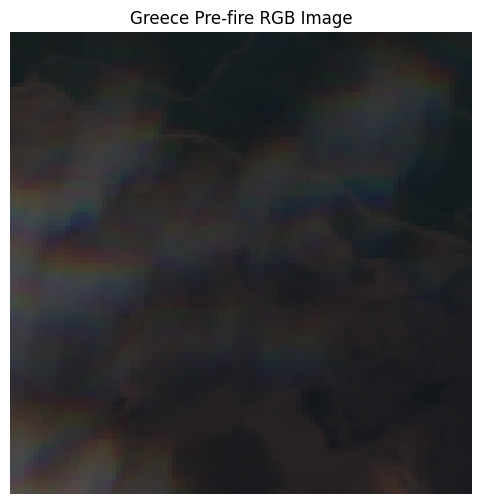

In [50]:
# Extract and display the image from the request
import matplotlib.pyplot as plt

greece_rgb_image = greece_rgb_request.get_data()[0]

plt.figure(figsize=(6, 6))
plt.imshow(greece_rgb_image)
plt.title("Greece Pre-fire RGB Image")
plt.axis('off')
plt.show()

In [ ]:
greece_rgb_request